# Script to plot GALAH spectra, but also save them into python dictionaries

## Author: Sven Buder (SB, MPIA) buder at mpia dot de

This script is intended to plot the 4 spectra of the arms of the HERMES spectrograph

History:
    181012 - SB created

In [1]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import os
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt

### Adjust script

### Definitions which will be executed in the last cell

In [89]:
def read_spectra(sobject_id, iraf_dr = 'dr5.3', SPECTRA = 'SPECTRA'):
    """
    This function reads in the 4 individual spectra from the subdirectory working_directory/SPECTRA
    
    INPUT:
    sobject_id = identifier of spectra by date (6digits), plate (4digits), combination (2digits) and pivot number (3digits)
    iraf_dr = reduction which shall be used, current version: dr5.3
    SPECTRA = string to indicate sub directory where spectra are saved
    
    OUTPUT
    spectrum = dictionary
    """
    
    spectrum = dict(sobject_id = sobject_id)
    
    # Assess if spectrum is stacked
    if str(sobject_id)[11] == '1':
        # Single observations are saved in 'com'
        com='com'
    else:
        # Stacked observations are saved in 'com2'
        com='com'   
    
    # Iterate through all 4 CCDs
    for each_ccd in [1,2,3,4]:
        
        try:
            fits = pyfits.open(SPECTRA+'/'+iraf_dr+'/'+str(sobject_id)[0:6]+'/standard/'+com+'/'+str(sobject_id)+str(each_ccd)+'.fits')

            # Extension 0: Reduced spectrum
            # Extension 1: Relative error spectrum
            # Extension 4: Normalised spectrum, NB: cut for CCD4

            # Extract wavelength grid for the reduced spectrum
            start_wavelength = fits[0].header["CRVAL1"]
            dispersion       = fits[0].header["CDELT1"]
            nr_pixels        = fits[0].header["NAXIS1"]
            reference_pixel  = fits[0].header["CRPIX1"]
            if reference_pixel == 0:
                reference_pixel = 1
            spectrum['wave_red_'+str(each_ccd)] = np.array(map(lambda x:((x-reference_pixel+1)*dispersion+start_wavelength),range(0,nr_pixels)))

            try:
                # Extract wavelength grid for the normalised spectrum
                start_wavelength = fits[4].header["CRVAL1"]
                dispersion       = fits[4].header["CDELT1"]
                nr_pixels        = fits[4].header["NAXIS1"]
                reference_pixel  = fits[4].header["CRPIX1"]
                if reference_pixel == 0:
                    reference_pixel=1
                spectrum['wave_norm_'+str(each_ccd)] = np.array(map(lambda x:((x-reference_pixel+1)*dispersion+start_wavelength),range(0,nr_pixels)))
            except:
                spectrum['wave_norm_'+str(each_ccd)] = spectrum['wave_red_'+str(each_ccd)]

            # Extract flux and flux error of reduced spectrum
            spectrum['sob_red_'+str(each_ccd)]  = np.array(fits[0].data)
            spectrum['uob_red_'+str(each_ccd)]  = np.array(fits[0].data * fits[1].data)

            # Extract flux and flux error of reduced spectrum
            try:
                spectrum['sob_norm_'+str(each_ccd)] = np.array(fits[4].data)
            except:
                spectrum['sob_norm_'+str(each_ccd)] = np.ones(len(fits[0].data))

            if each_ccd != 4:
                try:
                    spectrum['uob_norm_'+str(each_ccd)] = np.array(fits[4].data * fits[1].data)
                except:
                    spectrum['uob_norm_'+str(each_ccd)] = np.array(fits[1].data)
            else:
                # for normalised error of CCD4, only used appropriate parts of error spectrum
                try:
                    spectrum['uob_norm_4'] = np.array(fits[4].data * (fits[1].data)[-len(spectrum['sob_norm_4']):])
                except:
                    spectrum['uob_norm_4'] = np.zeros(len(fits[0].data))
            fits.close()
        except:
            
            spectrum['wave_norm_'+str(each_ccd)] = np.arange(7693.50,7875.55,0.074)
            spectrum['wave_red_'+str(each_ccd)] = np.arange(7693.50,7875.55,0.074)
            spectrum['sob_norm_'+str(each_ccd)] = np.ones(len(spectrum['wave_red_'+str(each_ccd)]))
            spectrum['sob_red_'+str(each_ccd)] = np.ones(len(spectrum['wave_red_'+str(each_ccd)]))
            spectrum['uob_norm_'+str(each_ccd)] = np.zeros(len(spectrum['wave_red_'+str(each_ccd)]))
            spectrum['uob_red_'+str(each_ccd)] = np.zeros(len(spectrum['wave_red_'+str(each_ccd)]))

    return spectrum

In [90]:
def interpolate_spectrum_onto_cannon_wavelength(spectrum):
    """
    This function interpolates the spectrum 
    onto the wavelength grid of The Cannon as used for GALAH DR2
    
    INPUT:
    spectrum dictionary
    
    OUTPUT:
    interpolated spectrum dictionary
    
    """
    
    # Initialise interpolated spectrum from input spectrum
    interpolated_spectrum = dict()
    for each_key in spectrum.keys():
        interpolated_spectrum[each_key] = spectrum[each_key]
    
    # The Cannon wavelength grid as used for GALAH DR2
    wave_cannon = dict()
    wave_cannon['ccd1'] = np.arange(4715.94,4896.00,0.046) # ab lines 4716.3 - 4892.3
    wave_cannon['ccd2'] = np.arange(5650.06,5868.25,0.055) # ab lines 5646.0 - 5867.8
    wave_cannon['ccd3'] = np.arange(6480.52,6733.92,0.064) # ab lines 6481.6 - 6733.4
    wave_cannon['ccd4'] = np.arange(7693.50,7875.55,0.074) # ab lines 7691.2 - 7838.5
    
    for each_ccd in [1, 2, 3, 4]:
        
        # exchange wavelength
        interpolated_spectrum['wave_red_'+str(each_ccd)]  = wave_cannon['ccd'+str(each_ccd)]
        interpolated_spectrum['wave_norm_'+str(each_ccd)] = wave_cannon['ccd'+str(each_ccd)]
        
        # interpolate and exchange flux
        interpolated_spectrum['sob_red_'+str(each_ccd)]  = np.interp(
            x=wave_cannon['ccd'+str(each_ccd)],
            xp=spectrum['wave_red_'+str(each_ccd)],
            fp=spectrum['sob_red_'+str(each_ccd)],
            )
        interpolated_spectrum['sob_norm_'+str(each_ccd)]  = np.interp(
            wave_cannon['ccd'+str(each_ccd)],
            spectrum['wave_norm_'+str(each_ccd)],
            spectrum['sob_norm_'+str(each_ccd)],
            )

        # interpolate and exchange flux error
        interpolated_spectrum['uob_red_'+str(each_ccd)]  = np.interp(
            wave_cannon['ccd'+str(each_ccd)],
            spectrum['wave_red_'+str(each_ccd)],
            spectrum['uob_red_'+str(each_ccd)],
            )
        interpolated_spectrum['uob_norm_'+str(each_ccd)]  = np.interp(
            wave_cannon['ccd'+str(each_ccd)],
            spectrum['wave_norm_'+str(each_ccd)],
            spectrum['uob_norm_'+str(each_ccd)],
            )

    return interpolated_spectrum

In [91]:
def plot_spectrum(spectrum, normalisation = True, lines_to_indicate = None, save_as_png = False):
    """
    This function plots the spectrum in 4 subplots for each arm of the HERMES spectrograph
    
    INPUT:
    spectrum = dictionary created by read_spectra()
    normalisation = True or False (either normalised or un-normalised spectra are plotted)
    save_as_png = Save figure as png if True
    
    OUTPUT:
    Plot that spectrum!
    
    """
    
    f, axes = plt.subplots(4, 1, figsize = (15,10))
    
    kwargs_sob = dict(c = 'k', label='Flux', rasterized=True)
    kwargs_error_spectrum = dict(color = 'grey', label='Flux error', rasterized=True)

    # Adjust keyword used for dictionaries and plot labels
    if normalisation==True:
        red_norm = 'norm'
    else:
        red_norm = 'red'
    
    for each_ccd in [1, 2, 3, 4]:

        axes[each_ccd-1].fill_between(
            spectrum['wave_'+red_norm+'_'+str(each_ccd)],
            spectrum['sob_'+red_norm+'_'+str(each_ccd)] - spectrum['uob_'+red_norm+'_'+str(each_ccd)],
            spectrum['sob_'+red_norm+'_'+str(each_ccd)] + spectrum['uob_'+red_norm+'_'+str(each_ccd)],
            **kwargs_error_spectrum
            )
        
        # Overplot observed spectrum a bit thicker
        axes[each_ccd-1].plot(
            spectrum['wave_'+red_norm+'_'+str(each_ccd)],
            spectrum['sob_'+red_norm+'_'+str(each_ccd)],
            **kwargs_sob
            )
        
        # Plot important lines if committed
        if lines_to_indicate != None:
            for each_line in lines_to_indicate:
                if (float(each_line[0]) >= spectrum['wave_'+red_norm+'_'+str(each_ccd)][0]) & (float(each_line[0]) <= spectrum['wave_'+red_norm+'_'+str(each_ccd)][-1]):
                    axes[each_ccd-1].axvline(float(each_line[0]), color = each_line[2], ls='dashed')
                    if red_norm=='norm':
                        axes[each_ccd-1].text(float(each_line[0]), 1.25, each_line[1], color = each_line[2], ha='left', va='top')
            
        # Plot layout
        if red_norm == 'norm':
            axes[each_ccd-1].set_ylim(-0.1,1.3)
        else:
            axes[each_ccd-1].set_ylim(0,1.3*np.median(spectrum['sob_'+red_norm+'_'+str(each_ccd)]))

        axes[each_ccd-1].set_xlabel(r'Wavelength CCD '+str(each_ccd)+' [$\mathrm{\AA}$]')
        axes[each_ccd-1].set_ylabel(r'Flux ('+red_norm+') [a.u.]')
        if each_ccd == 1:
            axes[each_ccd-1].legend(loc='lower left')
    plt.tight_layout()
    
    if save_as_png == True:
        plt.savefig(str(spectrum['sobject_id'])+'_'+red_norm+'.png', dpi=200)

    return f

### Execute and have fun looking at spectra

In [92]:
# Adjust directory you want to work in
working_directory = '/Users/buder/trunk/GALAH/'
working_directory = '/avatar/buder/trunk/GALAH/'

os.chdir(working_directory)

# You can activate a number of lines that will be plotted in the spectra
important_lines = np.array([
    [4861.35, 'H' , 'red'],
    [6562.79, 'H' , 'red'],
    [6708.  , 'Li', 'orange'],
    ])

# Last but not least, declare which sobject_ids shall be plotted


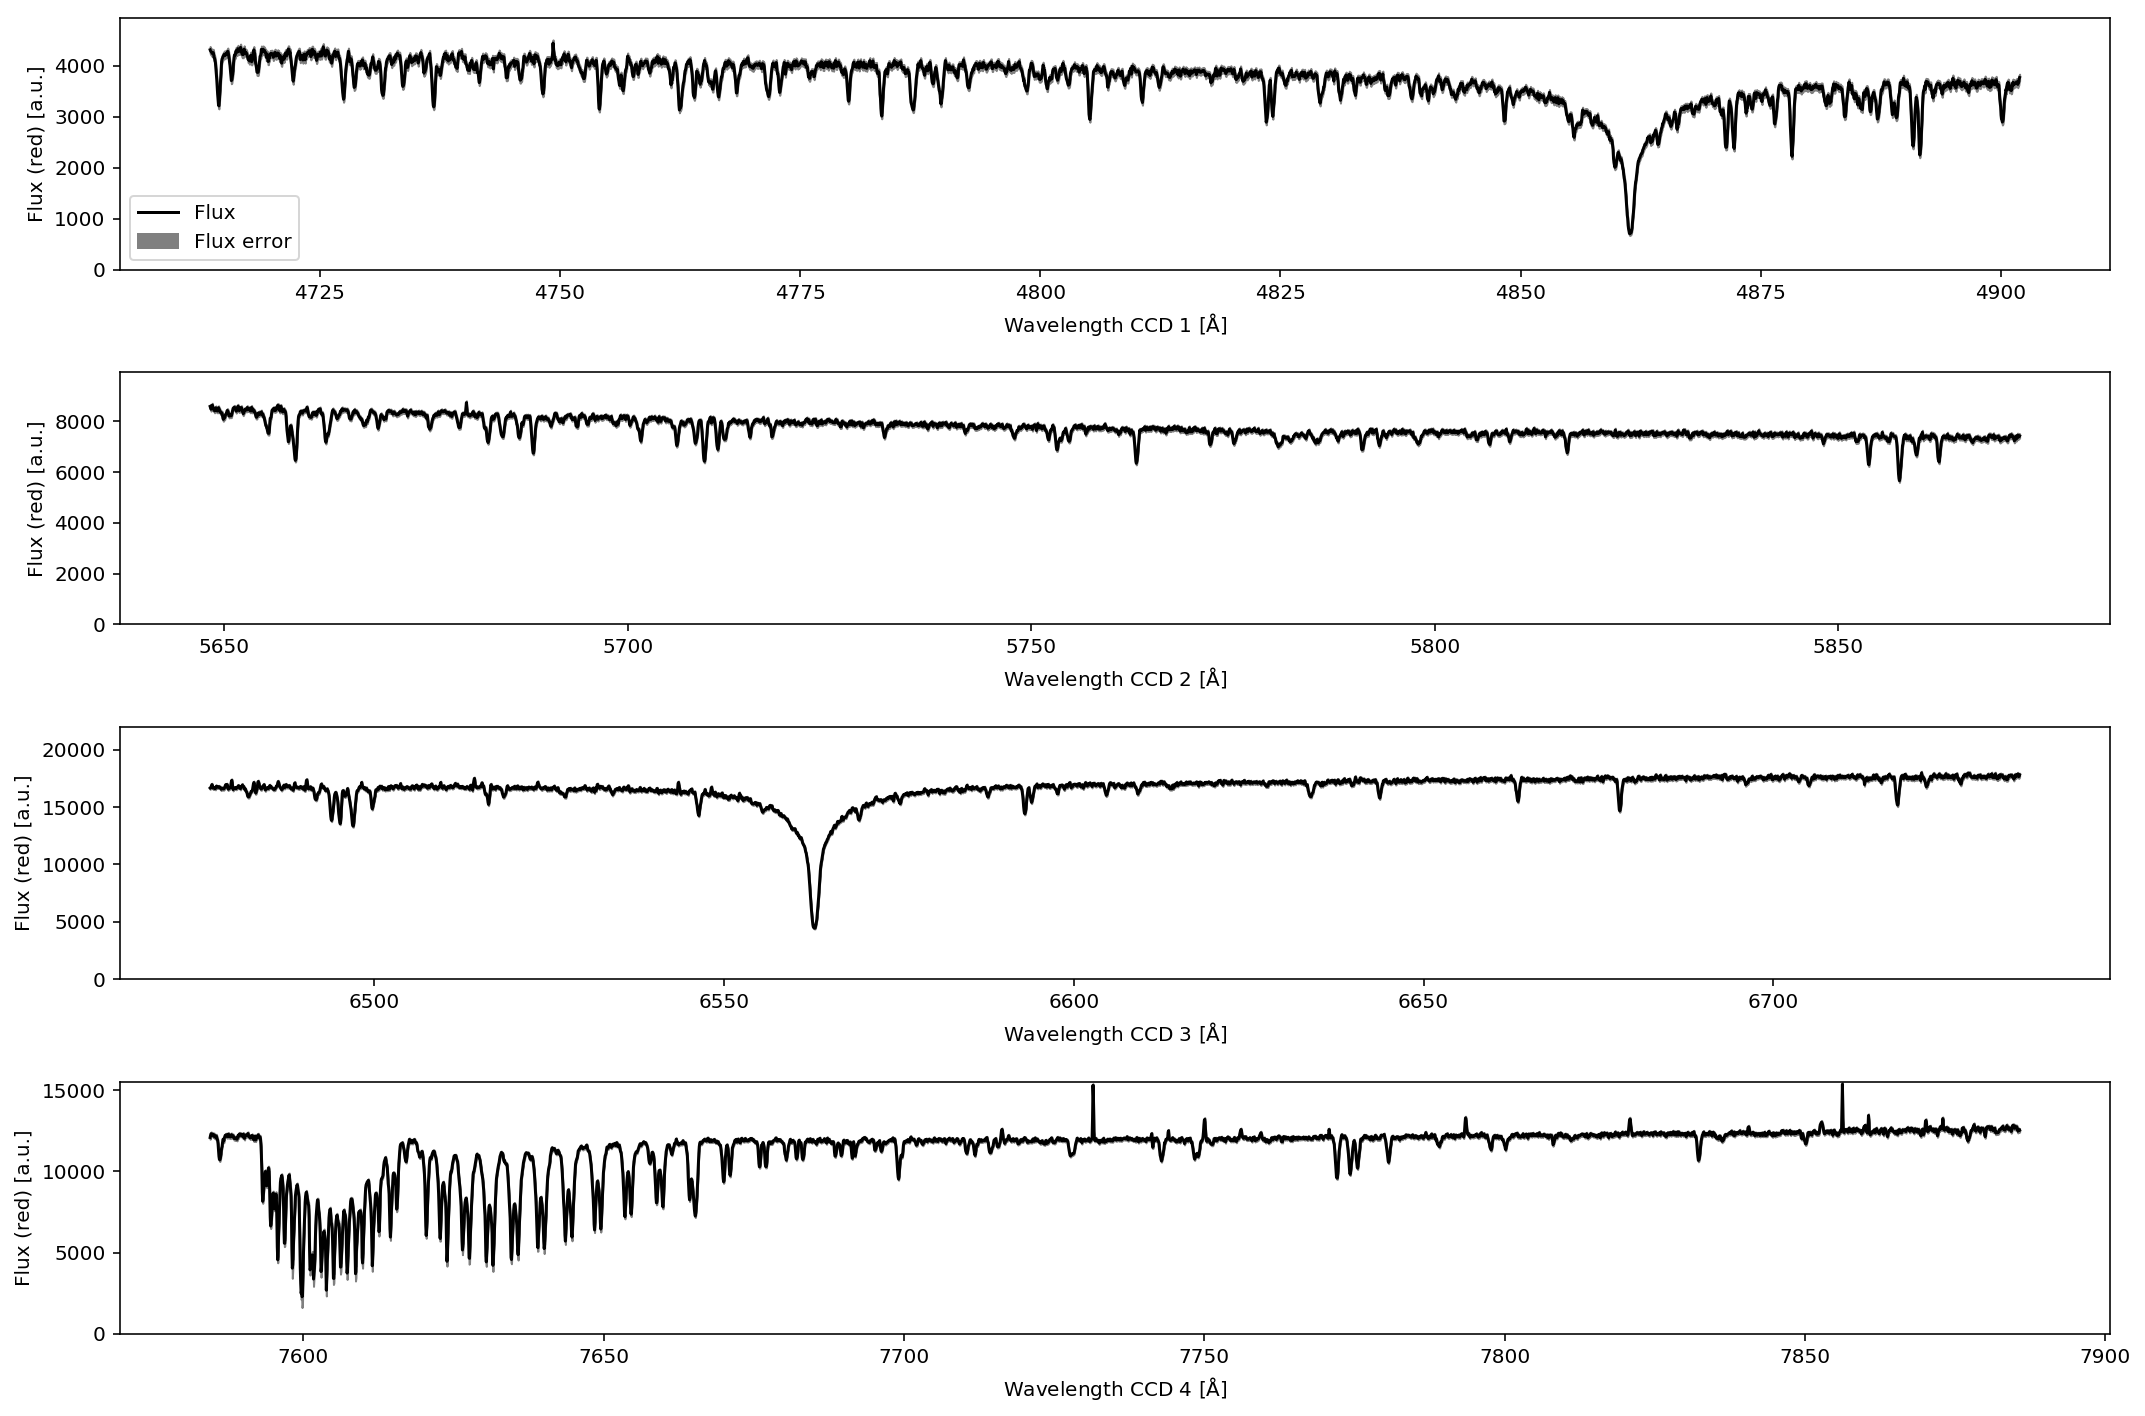

In [137]:
sobject_ids_to_plot = [
    190211002201088
    ]
for each_sobject_id in sobject_ids_to_plot:
    # read in spectrum
    spectrum = read_spectra(each_sobject_id)    
    # interpolate spectrum onto The Cannon wavelength grid
    interpolated_spectrum = interpolate_spectrum_onto_cannon_wavelength(spectrum)
    # plot input spectrum
    plot_spectrum(spectrum,
        normalisation = False,
        lines_to_indicate = None,
        save_as_png = True
    )
#     # plot interpolated spectrum
#     plot_spectrum(
#         interpolated_spectrum,
#         normalisation = True,
#         lines_to_indicate = None,
#         save_as_png = True
#     )